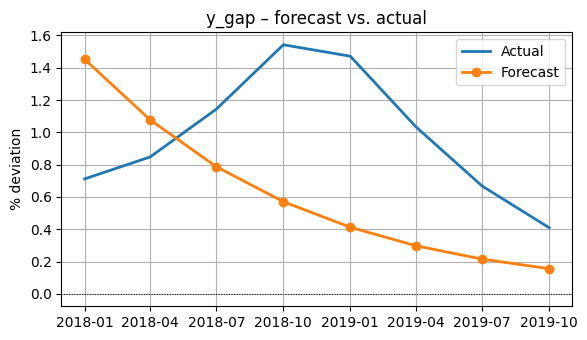

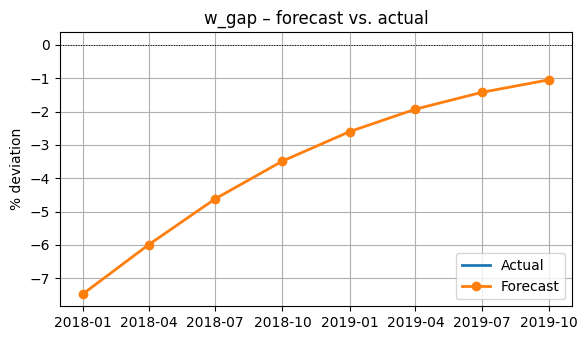

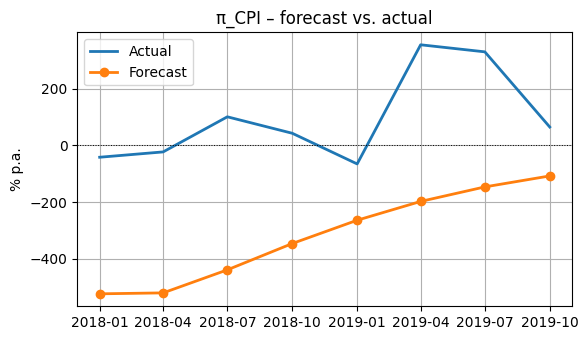

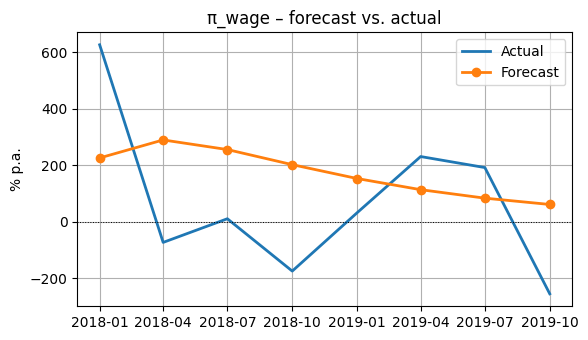

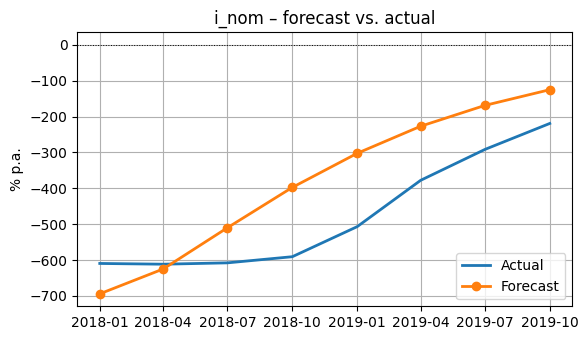

RMSE in deviation space
  y_gap : 0.00672
  π_CPI : 0.01092
  π_wage: 0.00704
  i_nom : 0.00334

RMSE in annual-percent / pct-gap space
  y_gap : 0.672
  π_CPI : 436.817
  π_wage: 281.492
  i_nom : 133.545


In [1]:
# ---------------------------------------------------------------------
# 0. Imports
# ---------------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, scipy.io
from sklearn.metrics import mean_squared_error

# ---------------------------------------------------------------------
# 1. Load Dynare results and processed EU data
# ---------------------------------------------------------------------
oo   = scipy.io.loadmat('nk_gali_sw_results.mat',
                        struct_as_record=False, squeeze_me=True)['oo_']
fc   = oo.PointForecast.Mean          # mean point-forecast struct
data = scipy.io.loadmat('eu_data.mat',
                        struct_as_record=False, squeeze_me=True)

# Dynare forecast horizon H = 8 (we verified shapes are (8,))
H          = 8
fc_y       = fc.y       [:H]             # HP-filtered output gap     (ln-deviation)
fc_wgap    = fc.wgap    [:H]             # wage gap (already deviation)
fc_pif_dev = fc.pif     [:H]             # demeaned quarterly decimal inflation
fc_piw_dev = fc.piw     [:H]             # demeaned quarterly decimal wage infl.
fc_i_dev   = fc.i       [:H]             # demeaned quarterly decimal rate

# ---------------------------------------------------------------------
# 2.  Grab matching actual observations (last H quarters in eu_data)
# ---------------------------------------------------------------------
obs_slice  = slice(-H, None)             # 2018Q1–2019Q4 in your sample
y_obs_dev  = data['y_obs'  ].flatten()[obs_slice]   # HP gap
pif_obs_dev= data['pinf_obs'].flatten()[obs_slice]  # demeaned decimal
piw_obs_dev= data['w_obs'   ].flatten()[obs_slice]
i_obs_dev  = data['r_obs'   ].flatten()[obs_slice]

# Wage-gap not directly observed  → keep NaN so it doesn’t break plotting
wgap_obs_dev = np.full(H, np.nan)

# ---------------------------------------------------------------------
# 3.  Back-transform deviations to interpretable units
#     • Output & wage gap stay as log-deviations (% approx ×100)
#     • Inflation & rate: add mean back, annualise & ×100
# ---------------------------------------------------------------------
mu_pif = data['pinf_obs'].mean()        # sample mean used for demeaning
mu_piw = data['w_obs'   ].mean()
mu_i   = data['r_obs'   ].mean()

def dev_to_annpct(x_dev, mu):
    """quarterly-decimal deviation → annualised % p.a."""
    return 400 * 100 * (x_dev + mu)     # ¼->one-year & ×100

pif_fc_pct = dev_to_annpct(fc_pif_dev, mu_pif)
piw_fc_pct = dev_to_annpct(fc_piw_dev, mu_piw)
i_fc_pct   = dev_to_annpct(fc_i_dev,   mu_i)

pif_obs_pct= dev_to_annpct(pif_obs_dev, mu_pif)
piw_obs_pct= dev_to_annpct(piw_obs_dev, mu_piw)
i_obs_pct  = dev_to_annpct(i_obs_dev,   mu_i)

# ---------------------------------------------------------------------
# 4.  Put everything in a tidy DataFrame for easy handling
# ---------------------------------------------------------------------
dates = pd.period_range('2018Q1', periods=H, freq='Q').to_timestamp()

df_fc  = pd.DataFrame({
    'y_gap'  : fc_y      * 100,          # convert ln-gap ≈ % to pp
    'w_gap'  : fc_wgap   * 100,
    'π_CPI'  : pif_fc_pct,
    'π_wage' : piw_fc_pct,
    'i_nom'  : i_fc_pct},  index=dates)

df_obs = pd.DataFrame({
    'y_gap'  : y_obs_dev  * 100,
    'w_gap'  : wgap_obs_dev,             # NaN (no obs)
    'π_CPI'  : pif_obs_pct,
    'π_wage' : piw_obs_pct,
    'i_nom'  : i_obs_pct}, index=dates)

# ---------------------------------------------------------------------
# 5.  Plot
# ---------------------------------------------------------------------
for col in df_fc.columns:
    plt.figure(figsize=(6,3.5))
    plt.plot(df_obs.index, df_obs[col], label='Actual',  lw=2)
    plt.plot(df_fc.index,  df_fc [col], label='Forecast',lw=2, marker='o')
    plt.axhline(0,color='k',lw=.7,ls=':')
    plt.title(f"{col} – forecast vs. actual")
    plt.ylabel({'π_CPI':'% p.a.',
                'π_wage':'% p.a.',
                'i_nom':'% p.a.'}.get(col,'% deviation'))
    plt.grid(); plt.legend(); plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 6.  RMSEs
#     a) in deviation space (what the Kalman filter actually targets)
#     b) in level / %-p.a. space for narrative
# ---------------------------------------------------------------------
print("RMSE in deviation space")
for name,a,f in [('y_gap',y_obs_dev,fc_y),
                 ('π_CPI',pif_obs_dev,fc_pif_dev),
                 ('π_wage',piw_obs_dev,fc_piw_dev),
                 ('i_nom', i_obs_dev, fc_i_dev)]:
    if np.isnan(a).any():               # skip gaps with no actuals
        continue
    print(f"  {name:6s}: {np.sqrt(mean_squared_error(a,f)):.5f}")

print("\nRMSE in annual-percent / pct-gap space")
for name,a,f in [('y_gap', df_obs['y_gap'], df_fc['y_gap']),
                 ('π_CPI',df_obs['π_CPI'], df_fc['π_CPI']),
                 ('π_wage',df_obs['π_wage'],df_fc['π_wage']),
                 ('i_nom', df_obs['i_nom'], df_fc['i_nom'])]:
    if a.isna().any():                  # skip if no actual
        continue
    print(f"  {name:6s}: {np.sqrt(mean_squared_error(a,f)):.3f}")


In [2]:
"""
Chunk 1 — Prepare DSGE-based data for the NN (8-quarter horizon)

• DSGE smoothed sample: 1980 Q1 – 2017 Q4  (190 obs → rows 0-189)
• Build (Xₜ, Yₜ₊₈) pairs ⇒ 182 usable pairs (t = 0-181, target t+8 = 8-189)
• Train on **all** 182 pairs — no internal hold-out
• Save:
      X_train_dsge.npy  (182, 5)   # inputs
      Y_train_dsge.npy  (182, 4)   # 8-step-ahead targets
      X_last_dsge.npy   (1,  5)    # row 189 = 2017 Q4, seed for 8-step forecast
      scaler_X.pkl, scaler_Y.pkl
"""

# --------------------------------------------------------------------------- #
# 0. Imports                                                                  #
# --------------------------------------------------------------------------- #
import scipy.io
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib                                           # to save scalers

# --------------------------------------------------------------------------- #
# 1. Parameters                                                               #
# --------------------------------------------------------------------------- #
HORIZON       = 8                                       # 8-quarter forecast
TARGET_VARS   = ['y', 'pif', 'piw', 'i']                # order matters
FILE_PATH_MAT = r"C:\Users\rusuf\Desktop\Running model\nk_gali_sw\Output\nk_gali_sw_results.mat"

# --------------------------------------------------------------------------- #
# 2. Load DSGE smoothed variables                                             #
# --------------------------------------------------------------------------- #
mat           = scipy.io.loadmat(FILE_PATH_MAT, simplify_cells=True)
smoothed_mean = mat["oo_"]["SmoothedVariables"]["Mean"]

# Verify required series exist
for var in TARGET_VARS:
    if var not in smoothed_mean:
        raise KeyError(f"Variable '{var}' not found in SmoothedVariables['Mean'].")

# DataFrame with **all** smoothed variables (target + others)
df_all = pd.DataFrame({var: smoothed_mean[var] for var in smoothed_mean})
print("✅ Extracted variables:", df_all.columns.tolist())    # should list y, pif, …

# --------------------------------------------------------------------------- #
# 3. Build (Xₜ, Yₜ₊₈) pairs                                                   #
# --------------------------------------------------------------------------- #
X_raw = df_all.iloc[:-HORIZON].values                 # rows 0..181  (182×5)
Y_raw = df_all[TARGET_VARS].iloc[HORIZON:].values     # rows 8..189  (182×4)
assert len(X_raw) == len(Y_raw) == 182

# --------------------------------------------------------------------------- #
# 4. Standardise — fit on **all** pairs                                       #
# --------------------------------------------------------------------------- #
scaler_X = StandardScaler().fit(X_raw)
scaler_Y = StandardScaler().fit(Y_raw)

X_train = scaler_X.transform(X_raw)                   # (182,5)
Y_train = scaler_Y.transform(Y_raw)                   # (182,4)

# --------------------------------------------------------------------------- #
# 5. Save numpy arrays & scalers                                              #
# --------------------------------------------------------------------------- #
np.save("X_train_dsge.npy", X_train)
np.save("Y_train_dsge.npy", Y_train)

# Single last-in-sample observation (2017 Q4) — seed for recursive forecast
X_last_raw = df_all.iloc[[-1]].values                 # row 189, shape (1,5)
X_last     = scaler_X.transform(X_last_raw)
np.save("X_last_dsge.npy", X_last)

# Persist scalers for inverse-transform later
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_Y, "scaler_Y.pkl")

# --------------------------------------------------------------------------- #
# 6. Quick report                                                             #
# --------------------------------------------------------------------------- #
print("✅ Data ready.")
print("X_train shape :", X_train.shape)
print("Y_train shape :", Y_train.shape)
print("X_last shape  :", X_last.shape)


✅ Extracted variables: ['y', 'pif', 'piw', 'i', 'wgap']
✅ Data ready.
X_train shape : (182, 5)
Y_train shape : (182, 4)
X_last shape  : (1, 5)


In [3]:
"""
Chunk 2 — Create TD-VAE training sequences (20 lags ➜ 8-step-ahead target)

• Inputs :  X_train_dsge.npy  (182, 5)
• Targets:  Y_train_dsge.npy  (182, 4)   ← already shifted by +8 quarters
• Window  : 20 consecutive quarters
• Output :
      X_tdvae_input.npy   (163, 20, 5)
      Y_tdvae_target.npy  (163,  4)
"""

# --------------------------------------------------------------------------- #
# 0. Imports & state-space matrix (if you need F later)                       #
# --------------------------------------------------------------------------- #
import numpy as np
import scipy.io
import torch

mat  = scipy.io.loadmat("nk_gali_sw_results.mat", simplify_cells=True)
F    = mat["oo_"]["dr"]["ghx"]                      # (n_states, n_states)
F_tensor = torch.tensor(F, dtype=torch.float32)     # not used yet

# --------------------------------------------------------------------------- #
# 1. Load scaled training arrays                                              #
# --------------------------------------------------------------------------- #
X_train = np.load("X_train_dsge.npy")    # (182, 5)
Y_train = np.load("Y_train_dsge.npy")    # (182, 4)

# --------------------------------------------------------------------------- #
# 2. Build 3-D sequences                                                      #
# --------------------------------------------------------------------------- #
sequence_length = 20           # use 20 past quarters
X_seq, Y_seq = [], []

# t runs from 19 … 181  →  163 windows
for t in range(sequence_length - 1, len(X_train)):
    X_seq.append(X_train[t-sequence_length+1 : t+1])   # rows (t-19)…t
    Y_seq.append(Y_train[t])                           # target already t+8

X_seq = np.array(X_seq)        # (163, 20, 5)
Y_seq = np.array(Y_seq)        # (163,  4)

# --------------------------------------------------------------------------- #
# 3. Save for the PyTorch TD-VAE model                                        #
# --------------------------------------------------------------------------- #
np.save("X_tdvae_input.npy", X_seq)
np.save("Y_tdvae_target.npy", Y_seq)

print("✅ TD-VAE data created.")
print("X_seq shape:", X_seq.shape)
print("Y_seq shape:", Y_seq.shape)


✅ TD-VAE data created.
X_seq shape: (163, 20, 5)
Y_seq shape: (163, 4)


In [4]:
"""
Chunk 3 — TD-VAE model with DSGE transition + shocks (general non-square ghx)
------------------------------------------------------------------------------
"""

# --------------------------------------------------------------------------- #
# 0) Imports & device                                                         #
# --------------------------------------------------------------------------- #
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import joblib
import scipy.io

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)

# --------------------------------------------------------------------------- #
# 1) Load training sequences                                                  #
# --------------------------------------------------------------------------- #
X_seq = np.load("X_tdvae_input.npy")     # (163, 20, 5)
Y_seq = np.load("Y_tdvae_target.npy")    # (163,  4)

X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y_seq, dtype=torch.float32).to(device)

batch_size = 32
dataset      = TensorDataset(X_tensor, Y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# --------------------------------------------------------------------------- #
# 2) Load DSGE matrices                                                       #
# --------------------------------------------------------------------------- #
mat = scipy.io.loadmat("nk_gali_sw_results.mat", simplify_cells=True)

F_np = mat["oo_"]["dr"]["ghx"]  # (n_next_states × n_current_states), here (14 × 5)
G_np = mat["oo_"]["dr"]["ghu"]  # (n_next_states × n_shocks)

F_tensor = torch.tensor(F_np, dtype=torch.float32)
G_tensor = torch.tensor(G_np, dtype=torch.float32)

n_next, n_curr = F_tensor.shape
n_shocks = G_tensor.shape[1]

print(f"📐 Shapes — ghx(F): {F_tensor.shape}, ghu(G): {G_tensor.shape}")

latent_dim = 16  # latent space dimension

# --------------------------------------------------------------------------- #
# 3) TD-VAE model                                                             #
# --------------------------------------------------------------------------- #
class TDVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, output_dim, F_tensor, G_tensor):
        super().__init__()
        self.encoder_rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu      = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar  = nn.Linear(hidden_dim, latent_dim)

        self.latent_gru = nn.GRU(latent_dim, latent_dim, batch_first=True)

        # Fixed DSGE matrices
        self.F = nn.Parameter(F_tensor.to(device), requires_grad=False)  # (n_next × n_curr)
        self.G = nn.Parameter(G_tensor.to(device), requires_grad=False)  # (n_next × n_shocks)

        # Projections latent ↔ DSGE state space
        self.to_dsge   = nn.Linear(latent_dim, self.F.shape[1])   # latent → n_curr
        self.from_dsge = nn.Linear(self.F.shape[0], latent_dim)   # n_next → latent

        self.decoder    = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def reparameterise(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)

    def forward(self, x):
        # Encode sequence → latent state
        _, (h_n, _) = self.encoder_rnn(x)
        h = h_n[-1]

        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z0     = self.reparameterise(mu, logvar)   # (B, latent_dim)

        # Project latent → DSGE current states (n_curr)
        x_curr = self.to_dsge(z0)   # (B, n_curr)

        # Deterministic transition
        x_next_det = x_curr @ self.F.T   # (B, n_next)

        # Shock contribution
        eps = torch.randn(x_curr.size(0), self.G.shape[1], device=z0.device)  # (B, n_shocks)
        shock_term = eps @ self.G.T     # (B, n_next)

        x_next = x_next_det + shock_term

        # Back to latent
        z_linear = self.from_dsge(x_next)   # (B, latent_dim)

        # Residual correction
        z_resid, _ = self.latent_gru(z0.unsqueeze(1))
        z_resid = z_resid.squeeze(1)

        # Combine
        z1 = z_linear + z_resid

        # Decode
        y_pred = self.decoder(z1)
        return y_pred, mu, logvar

# --------------------------------------------------------------------------- #
# 4) Instantiate model, loss, optimiser                                       #
# --------------------------------------------------------------------------- #
input_dim  = X_seq.shape[2]          # 5
hidden_dim = 32
output_dim = Y_seq.shape[1]          # 4

model = TDVAE(input_dim, latent_dim, hidden_dim, output_dim, F_tensor, G_tensor).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

# --------------------------------------------------------------------------- #
# 5) Training loop                                                            #
# --------------------------------------------------------------------------- #
epochs = 500
for epoch in range(epochs):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        yhat, mu, logvar = model(xb)

        mse = loss_fn(yhat, yb)
        mb  = xb.size(0)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mb

        loss = mse + 1e-3 * kld
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        running += loss.item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | loss = {running/len(train_loader):.6f}")

# --------------------------------------------------------------------------- #
# 6) Save model weights                                                       #
# --------------------------------------------------------------------------- #
torch.save(model.state_dict(), "tdvae_dsge_8q_model.pt")
print("✅ Model with DSGE prior + shocks saved → tdvae_dsge_8q_model.pt")


🚀 Using device: cpu
📐 Shapes — ghx(F): torch.Size([14, 5]), ghu(G): torch.Size([14, 4])
Epoch  20 | loss = 0.384272
Epoch  40 | loss = 0.339506
Epoch  60 | loss = 0.309578
Epoch  80 | loss = 0.272638
Epoch 100 | loss = 0.212362
Epoch 120 | loss = 0.205001
Epoch 140 | loss = 0.151009
Epoch 160 | loss = 0.148040
Epoch 180 | loss = 0.124401
Epoch 200 | loss = 0.147639
Epoch 220 | loss = 0.106437
Epoch 240 | loss = 0.128269
Epoch 260 | loss = 0.100868
Epoch 280 | loss = 0.092595
Epoch 300 | loss = 0.087664
Epoch 320 | loss = 0.084021
Epoch 340 | loss = 0.083943
Epoch 360 | loss = 0.085811
Epoch 380 | loss = 0.080415
Epoch 400 | loss = 0.071505
Epoch 420 | loss = 0.069225
Epoch 440 | loss = 0.087061
Epoch 460 | loss = 0.080104
Epoch 480 | loss = 0.066670
Epoch 500 | loss = 0.082273
✅ Model with DSGE prior + shocks saved → tdvae_dsge_8q_model.pt


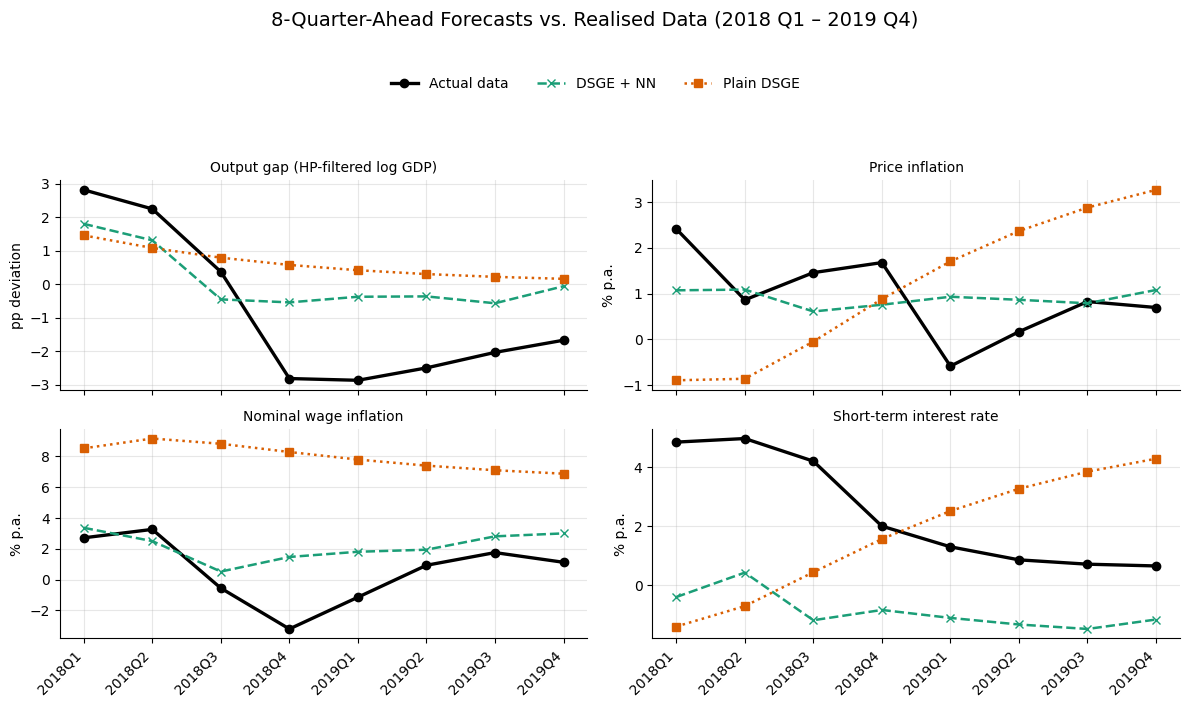

In [6]:
#V1 ---------------------------------------------------------------- 7. fresh build, back-transform, plot
import scipy.io, matplotlib.pyplot as plt, numpy as np, pandas as pd, joblib, torch

# -- 7-A. Rebuild required arrays if missing ---------------------------------
variables = ['y','pif','piw','i']

# Actual data (2018Q1–2019Q4 slice)
eu = scipy.io.loadmat("eu_data.mat", simplify_cells=True)
start_idx = (2018 - 1980) * 4
end_idx   = start_idx + 8
actual_arr = np.column_stack([
    eu['y_obs'][start_idx:end_idx],
    eu['pinf_obs'][start_idx:end_idx],
    eu['w_obs'][start_idx:end_idx],
    eu['r_obs'][start_idx:end_idx]
])   # shape (8,4)

# DSGE forecast
dsge_mat = scipy.io.loadmat("nk_gali_sw_results.mat", simplify_cells=True)
pf_mean = dsge_mat["oo_"]["PointForecast"]["Mean"]
dsge_forecast = np.column_stack([pf_mean[v][:8] for v in variables])  # (8,4)

# ---------------------------------------------------- NN forecast (2018Q1–2019Q4)
import torch, numpy as np, joblib, scipy.io

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variables = ['y','pif','piw','i']

# reload model and scalers
input_dim, latent_dim, hidden_dim, output_dim = 5, 16, 32, len(variables)
model = TDVAE(input_dim, latent_dim, hidden_dim, output_dim, F_tensor, G_tensor).to(device)
model.load_state_dict(torch.load("tdvae_dsge_8q_model.pt", map_location=device))
model.eval()

scaler_X = joblib.load("scaler_X.pkl")
scaler_Y = joblib.load("scaler_Y.pkl")

# load training inputs (scaled)
X_train_scaled = np.load("X_train_dsge.npy")   # (182,5)
window = X_train_scaled[-20:].copy()           # last 20 quarters up to 2017Q4

nn_preds_scaled = []
with torch.no_grad():
    for _ in range(8):  # 8-quarter forecast
        inp = torch.tensor(window[np.newaxis], dtype=torch.float32).to(device)
        y_scaled, _, _ = model(inp)
        y_scaled = y_scaled.squeeze(0).cpu().numpy()   # (4,)
        nn_preds_scaled.append(y_scaled)

        # recursive update: feed predictions back in
        next_row = window[-1].copy()
        next_row[:4] = y_scaled
        window = np.vstack([window[1:], next_row])

nn_preds_scaled = np.array(nn_preds_scaled)            # (8,4)
nn_forecast = scaler_Y.inverse_transform(nn_preds_scaled)  # back to levels


# -- 7-B. Build a clean DataFrame --------------------------------------------
quarters = pd.period_range("2018Q1", periods=8, freq='Q')
plot_df = pd.DataFrame(
    np.hstack([actual_arr, dsge_forecast, nn_forecast]),
    index=quarters,
    columns=[f"{v}_ACT" for v in variables] +
            [f"{v}_DSGE" for v in variables] +
            [f"{v}_NN"   for v in variables]
)

# -- 7-C. Load means and back-transform --------------------------------------
means = scipy.io.loadmat("eu_data_means.mat", simplify_cells=True)
pif_mean, piw_mean, r_mean = [float(means[k]) for k in ("pif_mean", "piw_mean", "r_mean")]

# Inflation & rate: convert quarterly decimal deviations ➜ % p.a.
for v, m in zip(['pif', 'piw', 'i'], [pif_mean, piw_mean, r_mean]):
    for key in ['ACT', 'DSGE', 'NN']:
        col = f"{v}_{key}"
        plot_df[col] = 100 * 4 * (plot_df[col] + m)

# Output gap: log deviation ×100
for key in ['ACT','DSGE','NN']:
    plot_df[f"y_{key}"] = 100 * plot_df[f"y_{key}"]

# -- 7-D. Plot settings -------------------------------------------------------
titles = {
    'y'  : 'Output gap (HP-filtered log GDP)',
    'pif': 'Price inflation',
    'piw': 'Nominal wage inflation',
    'i'  : 'Short-term interest rate'
}
ylab = {'y': 'pp deviation', 'pif': '% p.a.', 'piw': '% p.a.', 'i': '% p.a.'}
style = {
    'ACT' : dict(color='black',   lw=2.4, marker='o', linestyle='-'),
    'NN'  : dict(color='#1b9e77', lw=1.8, marker='x', linestyle='--'),
    'DSGE': dict(color='#d95f02', lw=1.8, marker='s', linestyle=':')
}

plt.rcParams.update({'axes.spines.top': False,
                     'axes.spines.right': False,
                     'axes.formatter.useoffset': False})

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
axes = axes.ravel()
t_labels = [p.strftime('%YQ%q') for p in quarters]

handles, used = [], set()
for ax, v in zip(axes, variables):
    for key, lab in zip(['ACT', 'NN', 'DSGE'],
                        ['Actual data', 'DSGE + NN', 'Plain DSGE']):
        line, = ax.plot(t_labels, plot_df[f"{v}_{key}"], label=lab, **style[key])
        if lab not in used:
            handles.append(line); used.add(lab)

    ax.set_title(titles[v], fontsize=10)
    ax.set_ylabel(ylab[v])
    ax.grid(alpha=.3)
    ax.ticklabel_format(style='plain', axis='y')

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.legend(handles, ['Actual data', 'DSGE + NN', 'Plain DSGE'],
           ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.08), frameon=False)
fig.suptitle('8-Quarter-Ahead Forecasts vs. Realised Data (2018 Q1 – 2019 Q4)',
             y=1.17, fontsize=14)

plt.tight_layout()
plt.show()
